# 0. Setup

## 0.1. Imports

In [356]:
import os
import random
import numpy as np

import torch
from torch.nn import functional as F

from part import Part
from graph import Graph

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

from graph_loader import load_graphs
from gensim.models import Word2Vec
from typing import Set, Dict, List, Tuple

## 0.2. Hyperparameters

In [357]:
SEED = 3
random.seed(SEED)

example_graph = 0

# Random Walks:
num_walks = 25
walk_length = 7

# Embedding model:
embedding_vector_size=16    # Size of the embedding vector
window=5                    # Context window size --> Wie viele Wörter außenherum werden beachtet? --> ca. 5, da Durchscnittliche größe der Graphen (Entscheidung von 2 auf 5 machte Unterschied)
min_count=1                 # Minimum occurrences of a node in the walks to include it in the vocabulary
sg=1                        # Use Skip-Gram (sg=1) instead of CBOW (sg=0)
workers=4                   # Number of CPU threads to use
embedding_model_epochs=20  # Number of training epochs
edge_threshold=0.5          # Threshold when an edge might be added

# GCN model:
gcn_input_dim = embedding_vector_size
gcn_hidden_dim = 32
gcn_output_dim = 16
gcn_learning_rate = 0.025
gcn_epochs = 5

# GAE model:
batch_size = 32                     # Adjust based on your GPU memory
gae_learning_rate = 0.01
gae_input_dim = embedding_vector_size   # Dimension of node embeddings (from Word2Vec)
gae_hidden_dim = 32
gae_latent_dim = 16
gae_epochs = 200

# 1 Process Training Data

## 1.1 Helper Functions

In [358]:
def create_part_list(graph_tuple):
    part_list = []
    nodes = graph_tuple[1].get_nodes()
    for node in nodes:
        part_list.append((node.get_id(), node.get_part().get_part_id()))
    return part_list

In [359]:
def create_edge_list(graph_tuple):
    edge_set = set()
    edges = graph_tuple[1].get_edges()
    for node, connected_nodes in edges.items():
        for connected_node in connected_nodes:

            # Store edges by node_ID and part_ID + node_ID and part_ID or source and target
            # Make sure each edge is only stored once (unidirectionally)
            edge = tuple(sorted((
                (node.get_id(), int(node.get_part().get_part_id())),
                (connected_node.get_id(), int(connected_node.get_part().get_part_id()))
            )))
            edge_set.add(edge)

    return list(edge_set)


In [360]:
def prepare_graph_data(graph_dataset):
    part_list_dict = {}
    edge_list_dict = {}

    for index, graph in enumerate(graph_dataset):
        part_list_dict[index] = create_part_list(graph)
        edge_list_dict[index] = create_edge_list(graph)

    # Sort the lists within the dictionaries
    for key in part_list_dict.keys():
        part_list_dict[key] = sorted(part_list_dict[key], key=lambda x: x[0])  # Sort by NodeID

    for key in edge_list_dict.keys():
        edge_list_dict[key] = sorted(edge_list_dict[key], key=lambda x: (x[0][0], x[1][0]))  # Sort edges by source and target

    return part_list_dict, edge_list_dict



## 1.2 Prepare Datasets

### 1.2.1 Graph Dataset

In [361]:
class GraphDataset(Dataset):
    def __init__(self, file_path: str, train=False, validation=False, test=False, seed=42):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found at {file_path}")

        self.graphs = load_graphs(file_path)

        if sum([train, validation, test]) != 1:
            raise ValueError("Exactly one of 'train', 'validation', or 'test' must be True.")

        # Create global mapping for unique parts
        self.family_part_dict = {}

        unique_parts = set()
        for graph in self.graphs:
            parts = graph.get_parts()
            for part in parts:
                unique_parts.add(int(part.get_part_id()))
                self.family_part_dict[int(part.get_part_id())] = int(part.get_family_id())

        # unique parts and mapping across all graphs (not just within a certain split)
        unique_parts = sorted(list(unique_parts))
        self.total_global_part_to_idx = {part: idx for idx, part in enumerate(unique_parts)} # mapping part_id to index
        self.idx_to_part_id = {idx: part for part, idx in self.total_global_part_to_idx.items()}  # Reverse mapping
        self.total_num_unique_parts = len(unique_parts)

        # Split: 70% training, 15% validation, 15% test
        train_graphs, test_graphs = train_test_split(self.graphs, test_size=0.3, random_state=seed)
        validation_graphs, test_graphs = train_test_split(test_graphs, test_size=0.5, random_state=seed)

        if train:
            self.graphs = train_graphs
        elif validation:
            self.graphs = validation_graphs
        elif test:
            self.graphs = test_graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        # return parts und graphen
        graph = self.graphs[idx]

        # Initialize a count vector for parts
        part_frequency_vector = np.zeros(self.total_num_unique_parts, dtype=np.int32)

        # Count occurrences of each part
        parts = graph.get_parts()
        for part in parts:
            part_id = int(part.get_part_id())
            mapped_id = self.total_global_part_to_idx[part_id]
            part_frequency_vector[mapped_id] += 1  # Increment the count

        # Ensure part_features is 2D
        part_frequency_vector = torch.tensor(part_frequency_vector, dtype=torch.float).unsqueeze(-1)

        return self.graphs[idx].get_parts(), self.graphs[idx]

### 1.2.2 Read Datasets

In [362]:
training_set = GraphDataset("data/graphs.dat", train = True, seed=SEED)
validation_set = GraphDataset("data/graphs.dat", validation = True, seed=SEED)
testing_set = GraphDataset("data/graphs.dat", test = True, seed=SEED)

print(len(training_set))
print(len(validation_set))
print(len(testing_set))

7811
1674
1674


### 1.2.3 Prepare Part and Edge Data for all graphs

In [363]:
"""
Dictionaries of key: graph-index / graph-id and lists of parts
"""
graph_parts_dict, graph_edge_dict = prepare_graph_data(training_set)

print(graph_parts_dict[0])


[(0, '1334'), (1, '168'), (2, '198'), (3, '83'), (4, '83'), (5, '58')]


## 1.3. Create Embeddings

Embeddings represent features of a node e.g. 16 features of Part 1 are 16 Embedding values

### 1.3.1. Random Walk Embeddings

In [364]:
def generate_random_walks_single_graph(edges):
    """
    Generate random walks for a single graph.

    Parameters:
        edges (list): Edge list for a single graph.
        num_walks (int): Number of random walks to generate per node.
        walk_length (int): Length of each random walk.

    Returns:
        list: A list of random walks, where each walk is a list of PartIDs.
    """
    # TODO in das ReadMe: Hier fraglich of random-walks funktionieren, da viel hin und her wegen non-cyclical
    # TODO Maximilian: Context


    walks = []
    graph = {}

    # Build adjacency list
    for edge in edges:
        node1, node2 = edge[0][1], edge[1][1]  # Extract PartIDs
        graph.setdefault(node1, []).append(node2)
        graph.setdefault(node2, []).append(node1)

    # Perform random walks
    for _ in range(num_walks):
        for node in graph.keys():
            walk = [node]  # Start the walk with the current node
            while len(walk) < walk_length:
                cur = walk[-1]  # Get the last node in the walk
                if cur in graph:
                    walk.append(random.choice(graph[cur]))  # Add a random neighbor
                else:
                    break
            walks.append(walk)  # Add the walk to the list of walks

    return walks

In [365]:
# Generate Random Walks for all graphs:
# execution Dauer: ca. 13 Sekunden (training), ca. 12 Sekunden (testing)

random_walks = {}
for index, graph in enumerate(training_set):
    random_walks[index] = generate_random_walks_single_graph(graph_edge_dict[index])
print(random_walks[example_graph])

[[1334, 198, 1334, 83, 1334, 58, 1334], [168, 1334, 83, 1334, 58, 1334, 198], [198, 1334, 58, 1334, 83, 1334, 198], [83, 1334, 58, 1334, 168, 1334, 198], [58, 1334, 83, 1334, 83, 1334, 58], [1334, 83, 1334, 83, 1334, 198, 1334], [168, 1334, 168, 1334, 83, 1334, 83], [198, 1334, 83, 1334, 58, 1334, 58], [83, 1334, 58, 1334, 58, 1334, 83], [58, 1334, 83, 1334, 83, 1334, 198], [1334, 58, 1334, 83, 1334, 168, 1334], [168, 1334, 168, 1334, 168, 1334, 198], [198, 1334, 83, 1334, 83, 1334, 168], [83, 1334, 83, 1334, 58, 1334, 58], [58, 1334, 168, 1334, 168, 1334, 168], [1334, 58, 1334, 198, 1334, 83, 1334], [168, 1334, 168, 1334, 83, 1334, 198], [198, 1334, 83, 1334, 58, 1334, 58], [83, 1334, 58, 1334, 83, 1334, 83], [58, 1334, 83, 1334, 58, 1334, 168], [1334, 83, 1334, 168, 1334, 58, 1334], [168, 1334, 83, 1334, 83, 1334, 58], [198, 1334, 83, 1334, 58, 1334, 168], [83, 1334, 83, 1334, 83, 1334, 198], [58, 1334, 198, 1334, 83, 1334, 83], [1334, 83, 1334, 168, 1334, 83, 1334], [168, 1334, 198,

### 1.3.2. Train Word2Vec Model with Random Walk Embeddings

In [366]:
"""
    flattening Dauer: instant
    training Dauer pro Epoche: 5s
"""
# Flattening the random walks to be able to train Embedding model on them:
# flat_random_walks Länge: 1.310.240
flat_random_walks = [walk for walks in random_walks.values() for walk in walks]

# Training embedding model:
word2vec_model = Word2Vec(
    sentences=flat_random_walks,
    vector_size=embedding_vector_size,
    window=window,
    min_count=min_count,
    sg=sg,
    workers=workers,
    epochs=embedding_model_epochs
)
word2vec_model.save("node_embeddings.model")
print("Embedding model saved \n")

Embedding model saved 



## 1.4. Prepare Training Data

In [367]:
# Create one parts-torch, one edge-torch and one label-torch for each graph:
all_graph_data = []

for graph_id in graph_parts_dict.keys():

    # Retrieve parts and edges for the current graph
    graph_parts = graph_parts_dict[graph_id]
    graph_edges = graph_edge_dict[graph_id]

    # 1. Extract Parts Features:
    parts_list = []
    for part in graph_parts:
        embedding = word2vec_model.wv[int(part[1])]
        parts_list.append(embedding)
    parts = torch.tensor(parts_list, dtype=torch.float)

    # 2. Extract Positive Edges:
    edge_index_list = []
    for edge in graph_edges:
        source_node = edge[0][0]
        target_node = edge[1][0]
        edge_index_list.append((source_node, target_node))
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

    # 3. Extract Negative Edges:
    num_nodes = len(graph_parts)
    all_edges = torch.combinations(torch.arange(num_nodes), r=2).T  # All possible edges
    all_edges = all_edges.to(edge_index.device)  # Ensure device compatibility

    # Identify negative edges
    neg_edge_mask = ~torch.any(
        (all_edges.unsqueeze(-1) == edge_index.unsqueeze(1)).all(dim=0), dim=1
    )
    neg_edge_index = all_edges[:, neg_edge_mask]

    # 4. Create Edge Labels:
    pos_edge_label = torch.ones(edge_index.size(1))  # Label 1 for positive edges
    neg_edge_label = torch.zeros(neg_edge_index.size(1))  # Label 0 for negative edges

    # Combine positive and negative edges:
    edge_index = torch.cat([edge_index, neg_edge_index], dim=1)
    edge_label = torch.cat([pos_edge_label, neg_edge_label], dim=0)

    # 5. Create Data Object for the Current Graph:
    single_graph_data = Data(
        x=parts,
        edge_index=edge_index,
        edge_label=edge_label  # Store labels for training
    )
    all_graph_data.append(single_graph_data)

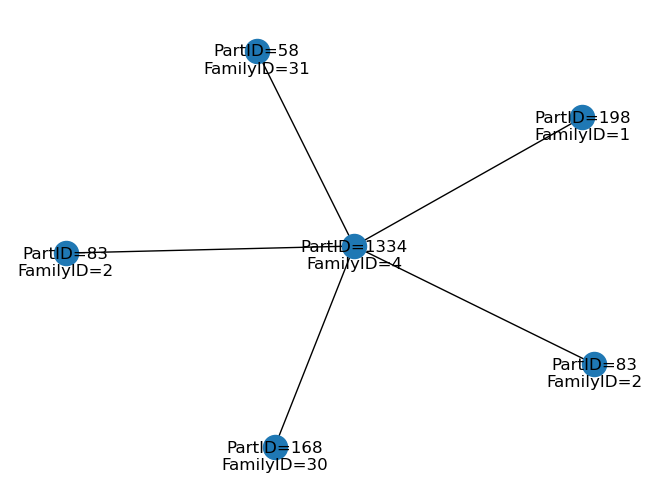

Data(x=[6, 16], edge_index=[2, 15], edge_label=[15])
tensor([[-3.8967e+00,  9.1144e-01, -4.5617e+00, -1.0642e+00,  3.0233e-02,
         -3.3881e-01, -3.3184e-01, -1.1942e+00, -2.1045e+00,  2.5544e+00,
         -1.3012e-01,  3.4669e-02,  1.2845e+00, -1.3365e+00, -2.3128e-01,
          7.9276e-01],
        [-2.4358e+00, -2.7518e-01, -2.6916e+00,  7.9001e-01, -3.0084e-01,
          6.8382e-01,  9.3734e-01, -1.7346e+00, -9.2481e-01,  1.0770e+00,
          9.9643e-01, -3.3568e-01,  2.1869e+00,  6.9833e-02, -2.2991e-01,
          1.7059e+00],
        [-3.3372e+00,  3.4036e-01, -8.6050e-01, -1.6041e+00, -1.7178e-01,
         -9.0129e-01, -9.2457e-01, -1.2093e-01,  8.2713e-01,  1.6800e+00,
         -2.3166e-01, -1.8544e+00, -3.3213e-01, -8.1931e-01, -5.8889e-02,
         -1.1699e+00],
        [ 1.2514e-01, -2.2394e-01, -2.8522e+00, -6.3130e-01, -2.3618e-01,
          4.7731e-01,  7.8845e-02,  9.0685e-02,  2.5351e-01,  1.3140e-01,
         -4.1523e-01,  1.2913e-02,  1.3646e+00,  6.5391e-02, -4.

In [368]:
# Verify the first Data object:
training_set[example_graph][1].draw()
print(all_graph_data[example_graph])
print(all_graph_data[example_graph].x)
print(all_graph_data[example_graph].edge_index)
print(all_graph_data[example_graph].edge_label)


# 3. Setup GNN

Recommended Model: GAE
GAE (Graph Autoencoder) is most suited for your problem because:
It encodes node features into latent space representations.
It uses a decoder to predict the existence of edges between nodes.
It is simple to set up for edge prediction tasks.

## 3.1 GAE

### 3.1.1 Define GAE

In [42]:
"""# Define Encoder
class GCNEncoderModel(torch.nn.Module):
    def __init__(self):
        super(GCNEncoderModel, self).__init__()
        self.conv1 = GCNConv(gae_input_dim, gae_hidden_dim)
        self.conv2 = GCNConv(gae_hidden_dim, gae_latent_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def encode(self, x, edge_index):
        return self.forward(x, edge_index)

    def decode(self, z, edge_index):
        return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1))


    def predict_graph(self, predict_parts: Set[Part]) -> Graph:

        # 0. Process Parts
        sorted_parts = sorted(predict_parts)
        print("sorted_parts", sorted_parts)

        # 1. Extract Parts Features:
        parts_list = []
        for part in sorted_parts:
            embedding = word2vec_model.wv[int(part[1])]
            parts_list.append(embedding)
        part_embeddings = torch.tensor(parts_list, dtype=torch.float)
        print("part embeddings", part_embeddings)

        # Step 2: Create a fully connected edge index for all parts
        num_parts = len(sorted_parts)
        edge_index = torch.combinations(torch.arange(num_parts), r=2).t().contiguous()
        print("Edge Index", edge_index)

        # Step 3: Encode parts into latent space
        z = self.encode(part_embeddings, edge_index)

        # Step 4: Decode edge probabilities
        edge_probs = self.decode(z, edge_index)
        print("Edge Probs", edge_probs)

        # Step 5: Filter edges by threshold
        predicted_edges = edge_index[:, edge_probs > edge_threshold]
        print("Predicted Edges", predicted_edges)

        # Step 6: Create graph structure from predictions
        # TODO es dürfen keine Zyklen entstehen -> Nach und nach höchstwahrscheinlichste kante hinzufügen
        graph = Graph()
        parts = {}
        for part in sorted_parts:
            new_part = Part(family_id=part[0], part_id=part[1])
            parts[part[1]] = new_part
            print(part[1])

        for edge in predicted_edges.t():
            source_id_tensor, target_id_tensor = edge.tolist()
            source_id_part_id = sorted_parts[source_id_tensor][1]
            target_id_part_id = sorted_parts[target_id_tensor][1]
            print(source_id_part_id, target_id_part_id)
            source_part = parts[source_id_part_id]
            target_part = parts[target_id_part_id]

            graph.add_undirected_edge(source_part, target_part)

        return graph

    # TODO hier aus GNN eine Adjazenzmatrix --> Dann simpel alle nehmen, die über threshold sind, daraus den Graphen aufbauen
"""

sorted_parts [(0, 1216), (1, 160), (2, 160), (3, 83), (4, 48)]
part embeddings tensor([[-0.0074,  0.6122,  2.1400,  1.8404,  1.3377, -1.7333, -0.5425,  1.6648,
          0.9343, -3.2593, -1.7829,  1.5213,  0.7858, -1.7640,  0.8795, -1.0112],
        [ 0.0518, -0.2473,  0.9797,  1.4874,  0.4808, -0.2426,  0.5741, -0.1754,
         -0.7157, -0.8861, -0.0266, -2.6413,  0.1686, -0.2392, -0.1034, -1.6602],
        [ 0.0518, -0.2473,  0.9797,  1.4874,  0.4808, -0.2426,  0.5741, -0.1754,
         -0.7157, -0.8861, -0.0266, -2.6413,  0.1686, -0.2392, -0.1034, -1.6602],
        [-0.0451,  0.0527,  0.8783,  0.1605,  0.1742,  0.2887,  0.9235, -0.3401,
          1.1500, -2.2010,  0.2177, -1.8923,  1.1383, -0.3369, -0.6892, -1.3745],
        [ 1.1292, -0.5533,  0.8302,  2.1472,  0.5440,  0.0592,  0.1307,  0.3803,
         -1.1162,  0.0594, -0.6057, -1.5056,  1.3466,  0.0339,  1.2504, -0.0519]])
Edge Index tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
        [1, 2, 3, 4, 2, 3, 4, 3, 4, 4]])
Edge Probs te

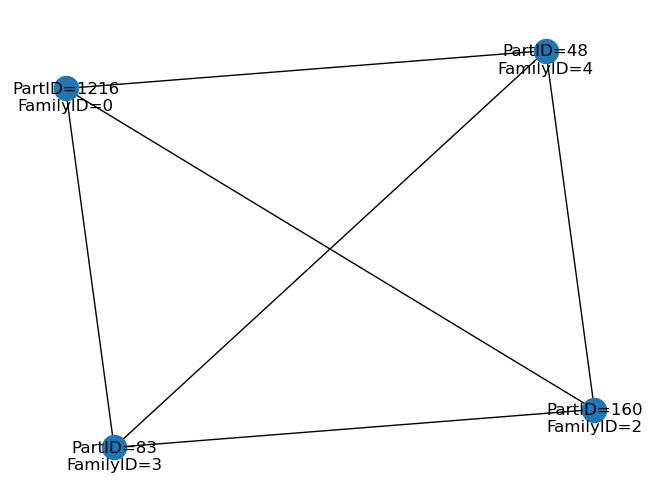

In [43]:
"""testing_list = []

for graph in validation_set:
    parts = create_part_list(graph)
    partList = []
    for part in parts:
        partList.append((part[0], int(part[1])))
    testing_list.append(partList)

gcn_model = GCNEncoderModel()
predicted_graph = gcn_model.predict_graph(testing_list[example_graph])
predicted_graph.draw()"""

### 3.1.2 Initialize the GAE

In [44]:
"""# Initialize GAE
encoder = GCNEncoderModel()
model = GAE(encoder)"""

### 3.1.3 Train GAE

For link prediction, the GAE minimizes the binary cross-entropy loss between the reconstructed edges and the ground-truth edges.

### 3.3.1 Data Loader to batch Graph-Data Objects

In [45]:
"""# Create a DataLoader for batching the graphs
loader = DataLoader(all_graph_data, batch_size=batch_size, shuffle=True)"""

In [47]:
"""# Prepare optimizer
optimizer = optim.Adam(model.parameters(), lr=gae_learning_rate)

# Define the training loop
def train(model, loader, optimizer):

    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(loader):

        # Reset gradients
        optimizer.zero_grad()

        # Encode node features into latent space
        z = model.encode(batch.x, batch.edge_index)

        edge_probs = model.decode(z, batch.edge_index)


        # Decode and compute reconstruction loss
        loss = model.recon_loss(z, batch.edge_index)

        # TODO wo vergleiche ich hier die tatsächlichen Edges und die

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

"""

'\n        # Print decoded edge probabilities for each graph\n        print(f"Batch {batch_idx + 1}/{len(loader)}:")\n        for graph_idx in range(batch.num_graphs):  # `num_graphs` indicates the number of graphs in the batch\n            print(f"  Graph {graph_idx + 1}:")\n            graph_mask = batch.batch == graph_idx  # Mask for nodes belonging to the current graph\n            graph_edges = batch.edge_index[:, graph_mask[batch.edge_index[0]]]  # Filter edges for this graph\n            graph_probs = edge_probs[graph_mask[batch.edge_index[0]]]  # Filter decoded probabilities for this graph\n            print(f"    Edges: {graph_edges.t().tolist()}")\n            print(f"    Decoded Probabilities: {graph_probs.tolist()}")\n'

In [48]:
"""for epoch in range(gae_epochs):
    loss = train(model, loader, optimizer)
    print(f"Epoch {epoch+1}/{gae_epochs}, Loss: {loss:.4f}")"""

Epoch 1/200, Loss: 1.0689
Epoch 2/200, Loss: 0.9520
Epoch 3/200, Loss: 0.9365
Epoch 4/200, Loss: 0.9292
Epoch 5/200, Loss: 0.9305
Epoch 6/200, Loss: 0.9271
Epoch 7/200, Loss: 0.9233
Epoch 8/200, Loss: 0.9212


KeyboardInterrupt: 

## 3.2 GCN

### 3.2.1 Define GCN


In [369]:
class GCN_Graph_Predictor(torch.nn.Module):
    def __init__(self):
        super(GCN_Graph_Predictor, self).__init__()
        self.conv1 = GCNConv(gcn_input_dim, gcn_hidden_dim)
        self.conv2 = GCNConv(gcn_hidden_dim, gcn_output_dim)

    def forward(self, x, edge_index):
        # print("Input to Conv1:", x)
        x = self.conv1(x, edge_index)
        # print("Output of Conv1:", x)
        x = F.relu(x)
        # print("After ReLU:", x)
        x = self.conv2(x, edge_index)
        # print("Output of Conv2:", x)
        return x

    def initialize_weights(self):
        """
        Initializes weights of the GCNConv layers using Xavier initialization
        and biases to zero.
        """
        for layer in self.modules():
            if isinstance(layer, GCNConv):
                torch.nn.init.xavier_uniform_(layer.lin.weight)  # Xavier initialization for weights
                if layer.lin.bias is not None:
                    torch.nn.init.zeros_(layer.lin.bias)  # Zero initialization for biases

    def train_model(self, data, optimizer):

        self.train()
        all_losses = []

        for epoch in range(gcn_epochs):
            total_loss = 0

            for i, graph_data in enumerate(data):
                optimizer.zero_grad()

                # Feed Forward:
                predictions = self(graph_data.x, graph_data.edge_index)                 # Using self(...) in pytorch always triggers the forward pass

                # Compute probabilistic adjacency matrix
                adjacency_logits = torch.mm(predictions, predictions.t())
                adjacency_probs = torch.sigmoid(adjacency_logits)
                adjacency_probs = adjacency_probs.clamp(min=1e-7, max=1 - 1e-7)             # To prevent invalid log inputs, clip the values of adjacency_probs to a small positive range away from 0 and 1
#                 if i == 1: print("Adjacency------------------ \n", adjacency_probs)

                # Loss computation using precomputed edge labels
                edge_probs = adjacency_probs[graph_data.edge_index[0], graph_data.edge_index[1]]
                loss = F.binary_cross_entropy(edge_probs, graph_data.edge_label)

                # Backpropagation
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Avg Loss for the epoche:
            avg_loss = total_loss / len(data)
            all_losses.append(avg_loss)
            print(f"Epoch {epoch + 1}/{gcn_epochs}, Loss: {avg_loss:.4f}")

        return all_losses

    def predict_graph(self, parts: Set[Part]) -> Graph:
        """
        Predicts a graph from the given set of parts.
        :param parts: Set of Part objects.
        :return: A predicted graph by the GCN
        """

        family_id_mapping = {}
        for part in parts:
            family_id_mapping[part.get_part_id()] = part.get_family_id()

        # Step 1: Sort and process parts
        parts = list(sorted(parts, key=lambda p: int(p.get_part_id())))  # Sort by Part ID
        part_ids = [int(p.get_part_id()) for p in parts]  # Extract Part IDs
        print("Part IDs:", part_ids)

        # Step 2: Convert Part IDs to embeddings
        part_embeddings = [word2vec_model.wv[part_id] for part_id in part_ids]
        x = torch.tensor(part_embeddings, dtype=torch.float)

        # Step 3: Create a Data object for querying
        edge_index = torch.empty((2, 0), dtype=torch.long)  # No edges for initial query
        query_data = Data(x=x, edge_index=edge_index)

        # Step 4: Pass data through the GCN model
        node_embeddings = self(query_data.x, query_data.edge_index)  # Forward pass
        adjacency_logits = torch.mm(node_embeddings, node_embeddings.t())
        adjacency_probs = torch.sigmoid(adjacency_logits)

        # Step 5: Generate adjacency matrix and edges
        threshold = 0.5  # Define threshold for edge prediction
        adjacency_matrix = (adjacency_probs > threshold).float()

        # Extract predicted edges
        edges = torch.nonzero(adjacency_matrix, as_tuple=False).t()
        edge_list = [(int(src), int(dst)) for src, dst in zip(edges[0], edges[1])]

        # Debugging: Print adjacency matrix and edge list
        print("Adjacency Matrix:\n", adjacency_matrix)
        print("Predicted Edges:", edge_list)

        return create_mst(family_id_mapping, edge_list, parts)


### 3.2.2 Initialize GCN

In [370]:
gcn_model = GCN_Graph_Predictor()
gcn_model.initialize_weights()
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=gcn_learning_rate)

### 3.2.3 Train GCN

In [371]:
gcn_model.train_model(all_graph_data, optimizer)

Epoch 1/5, Loss: 11.3498
Epoch 2/5, Loss: 11.3524
Epoch 3/5, Loss: 11.3524
Epoch 4/5, Loss: 11.3524
Epoch 5/5, Loss: 11.3524


[11.349785532204752,
 11.352398024678552,
 11.352398024678552,
 11.352398024678552,
 11.352398024678552]

# 6. Evaluate Model

### 6.1.1 Create Testing List

In [372]:
testing_list = []

for graph in validation_set:
    parts = create_part_list(graph)
    partList = []
    for part in parts:
        partList.append(Part(family_id=part[0], part_id=part[1]))
    testing_list.append(partList)

print(len(testing_list))
print(testing_list[6])

1674
[Part(PartID=102, FamilyID=1), Part(PartID=103, FamilyID=4), Part(PartID=48, FamilyID=6), Part(PartID=901, FamilyID=0), Part(PartID=114, FamilyID=9), Part(PartID=111, FamilyID=3), Part(PartID=57, FamilyID=2), Part(PartID=11, FamilyID=5), Part(PartID=114, FamilyID=10), Part(PartID=165, FamilyID=8), Part(PartID=48, FamilyID=7)]


### 6.1.2 Test Prediction

Part IDs: [7, 9, 48, 77, 82, 82, 83, 83, 106, 143, 143, 143, 160, 342, 630, 686]
Adjacency Matrix:
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1.,

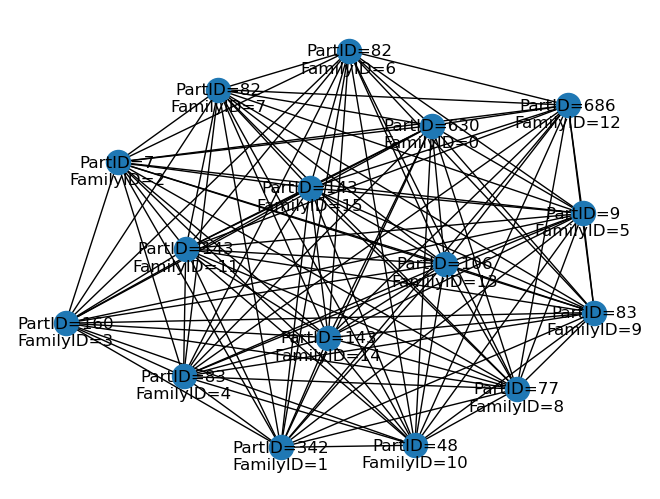

In [376]:
gcn_model = GCN_Graph_Predictor()
predicted_graph = gcn_model.predict_graph(testing_list[9])
# predicted_graph.draw()

In [374]:
def create_mst(
    family_id_mapping: Dict[int, int],
    edge_list: List[Tuple[int, int]],
    parts: List[Part],
) -> Graph:
    """
    Creates a minimum spanning tree (MST) using the adjacency matrix and part IDs.
    """
    # Step 1: Create a NetworkX graph from adjacency matrix
    building_graph = Graph()

    building_parts_list = {}
    for part in parts:
        print(part)

    for edge in edge_list:
        source_index = edge[0]
        target_index = edge[1]
        building_graph.add_undirected_edge(parts[source_index], parts[target_index])

    building_graph.draw()

    return building_graph